In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_regression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Задание 1.
В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

Я реализовал останову min_samples_split в функции find_best_split(). Эта останова указывает модели минимальное количество элементов в выборке для того, чтобы сделать разбивку в узле. Если выборка меньше, то узел разбиваться не будет.

In [2]:
# сгенерируем данные
classification_data, classification_labels = make_classification(n_samples=1000, n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=5)

In [3]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [4]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [5]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [6]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [7]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [8]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 10
    # ИЗМЕНЕНИЕ
    # Добавил min_samples_split, который разрешает сплитить node, только в случае, 
    # если там объем выборки больше данного значения.
    min_samples_split = 100

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            
            ## ИЗМЕНЕНИЯ
            if min_samples_split > len(data):
                continue
            ## ИЗМЕНЕНИЯ
            
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [9]:
import time
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)

    #print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels)
    
    #print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [10]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [11]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [12]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [13]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [14]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0 <= -0.001967524769128759
--> True:
  Индекс 1 <= -1.3993975578815423
  --> True:
    Индекс 1 <= -1.6646404646216442
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Индекс 1 <= -1.4518330557811816
  --> True:
    Прогноз: 0
  --> False:
    Индекс 0 <= 0.08948763365897339
    --> True:
      Прогноз: 1
    --> False:
      Индекс 0 <= 1.2003150546431454
      --> True:
        Индекс 0 <= 1.1157283896415566
        --> True:
          Индекс 1 <= -1.0609167140093252
          --> True:
            Прогноз: 1
          --> False:
            Прогноз: 1
        --> False:
          Прогноз: 1
      --> False:
        Прогноз: 1


In [15]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [16]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [17]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [18]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

95.14285714285714

In [19]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

94.0

##  Задание 2.

*Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

Ниже я укажу только те функции, которые изменяю.

class Node, Split(), build_tree(), classify_object(), predict() остались без изменений.

In [20]:
# сгенерируем данные
regression_data, regression_labels = make_regression(n_samples=1000, n_features=2, n_informative=2,
                                                                    random_state=5, noise=5)

In [21]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):  
        ## ИЗМЕНЕНИЕ предикт это среднее
        prediction = np.mean(self.labels)
        return prediction        

In [22]:
# MSE для регрессии

def mse(labels):
    mean = labels.mean()
    return np.mean((labels - mean)**2)

In [23]:
# Расчет прироста

def gain(left_labels, right_labels, root_mse):

    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    ## ИЗМЕНЕНИЯ изменил gini на mse для регрессии.
    return root_mse - p * mse(left_labels) - (1 - p) * mse(right_labels)

In [24]:
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 5
    
    # ИЗМЕНЕНИЕ на mse
    root_mse = mse(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_mse)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [25]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(regression_data, 
                                                                    regression_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [26]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [27]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [28]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [29]:
# Для измерения качества предсказаний регрессионной модели создадим функцию для подсчета r^2.
def r2(true, pred):
    return 1 - (sum((true - pred)**2)/len(true))/(sum((true - np.mean(true))**2)/len(true))

In [30]:
# r^2 на обучающей выборке
train_R2 = r2(train_labels, train_answers)
train_R2

0.9834708910536218

In [31]:
# r^2 на тестовой выборке
test_R2 = r2(test_labels, answers)
test_R2

0.956330287832153

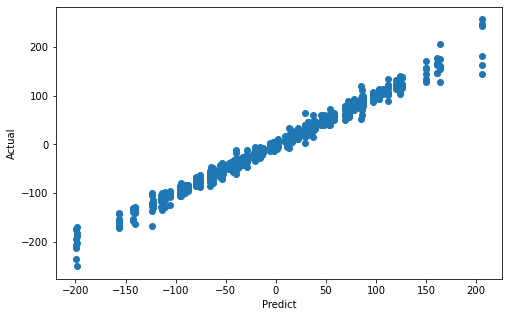

In [32]:
plt.figure(figsize=[8, 5])
plt.scatter(train_answers, train_labels)
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show();